In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

In [ ]:
description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))

In [ ]:
train.shape

In [ ]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

In [ ]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [ ]:
xgb_model.save_model('data/14.xgboost_model_save.xgb')
make_submission('data/14.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

In [ ]:
# description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))
description, test1 = pickle.load(open('data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)

In [ ]:
test1.tail()

In [ ]:
test2.head()

In [ ]:
print test.shape
test.head()

In [ ]:
final_test = xgb.DMatrix(test)

xgb_model = xgb.Booster(model_file='data/14.xgboost_model_save.xgb')

preds = xgb_model.predict(final_test)

In [ ]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

In [ ]:
gc.collect()

In [ ]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

In [ ]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv'
description = '14. (feature engineering was done in 13.)\
               xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

In [ ]:
filename = 'data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv'
pickle_description = '14. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

---
# Remove older user attributes, just changes
---

In [ ]:
description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))

description, test1 = pickle.load(open('data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)

In [ ]:
del test['xgb_preds'], test['added_products']

In [ ]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

In [ ]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

In [ ]:
print train.shape
print test.shape

In [ ]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [ ]:
xgb_model.save_model('data/14.1.xgboost_model_save.xgb')
make_submission('data/14.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

In [ ]:
final_test = xgb.DMatrix(test)

preds = xgb_model.predict(final_test)

In [ ]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

In [ ]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.1.xgb_trained_on_all_months_user_attr_lags_subs_lags_and_no_attr_raw_lags.csv'
description = '14.1 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

In [ ]:
pickle_description = '14.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

---
# remove the user attr changes
---

In [ ]:
del test['xgb_preds'], test['added_products']

In [ ]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

#  df.set_value(i, 'uf1_changed_recently_' + col, user_features[0])
#             df.set_value(i, 'uf2_changed_earlier_' + col, user_features[1])
#             df.set_value(i, 'uf3_times_changed_' + col, user_features[2])
for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

In [ ]:
print train.shape
print test.shape

In [ ]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 250
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

In [ ]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

In [ ]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [ ]:
xgb_model.save_model('data/14.2.xgboost_model_save.xgb')
make_submission('data/14.2.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

In [ ]:
final_test = xgb.DMatrix(test)

preds = xgb_model.predict(final_test)

In [ ]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

In [ ]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.2.xgb_trained_on_all_months_subs_lags_250iters.csv'
description = '14.2 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               removed user attribute change features also\
               xgb model 250 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=False, compress=True, upload_to_s3=True)

In [ ]:
pickle_description = '14.2 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

---
# Finding the optimum n_iter
---

In [ ]:
def test_train_split_wt(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

In [ ]:
del test['xgb_preds'], test['added_products']

In [ ]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

In [ ]:
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 400
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

In [ ]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

In [ ]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
p2.loc[p2.map7_cv == p2.map7_cv.max(), :].index.max()

In [ ]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

In [ ]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

In [124]:
# optimal n in this case was found to be 116
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[19]	train-MAP@7:0.770155	cv-MAP@7:0.765782
[20]	train-MAP@7:0.770217	cv-MAP@7:0.765827
[21]	train-MAP@7:0.770384	cv-MAP@7:0.765873
[22]	train-MAP@7:0.770572	cv-MAP@7:0.765963
[23]	train-MAP@7:0.770887	cv-MAP@7:0.766235
[24]	train-MAP@7:0.771066	cv-MAP@7:0.766552
[25]	train-MAP@7:0.771218	cv-MAP@7:0.766597
[26]	train-MAP@7:0.771423	cv-MAP@7:0.767005
[27]	train-MAP@7:0.77164	cv-MAP@7:0.766914
[28]	train-MAP@7:0.771759	cv-MAP@7:0.767322
[29]	train-MAP@7:0.77184	cv-MAP@7:0.767095
[30]	train-MAP@7:0.772005	cv-MAP@7:0.767231
[31]	train-MAP@7:0.772074	cv-MAP@7:0.767367
[32]	train-MAP@7:0.772174	cv-MAP@7:0.767594
[33]	train-MAP@7:0.772298	cv-MAP@7:0.767548
[34]	train-MAP@7:0.772446	cv-MAP@7:0.767594
[35]	train-MAP@7:0.772624	cv-MAP@7:0.767639
[36]	train-MAP@7:0.77276	cv-MAP@7:0.76782
[37]	train-MAP@7:0.772832	cv-MAP@7:0.767956
[38]	train-MAP@7:0.772946	cv-MAP@7:0.767594
[39]	train-MAP@7:0.773077	cv-MAP@7:0.76782
[40]	train-MAP@7:0.773144	cv-MAP@7:0.768137
[41]	train-MAP@7:0.773275	cv-MAP@7:0.

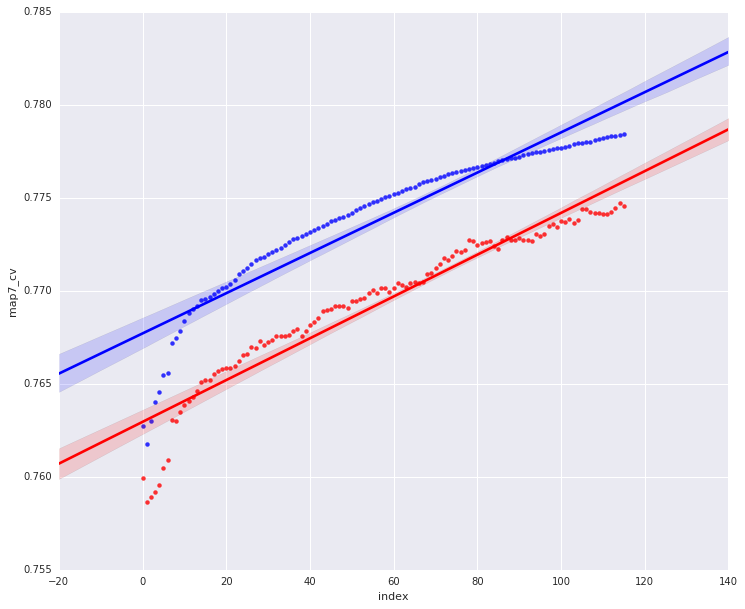

time: 411 ms


In [126]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

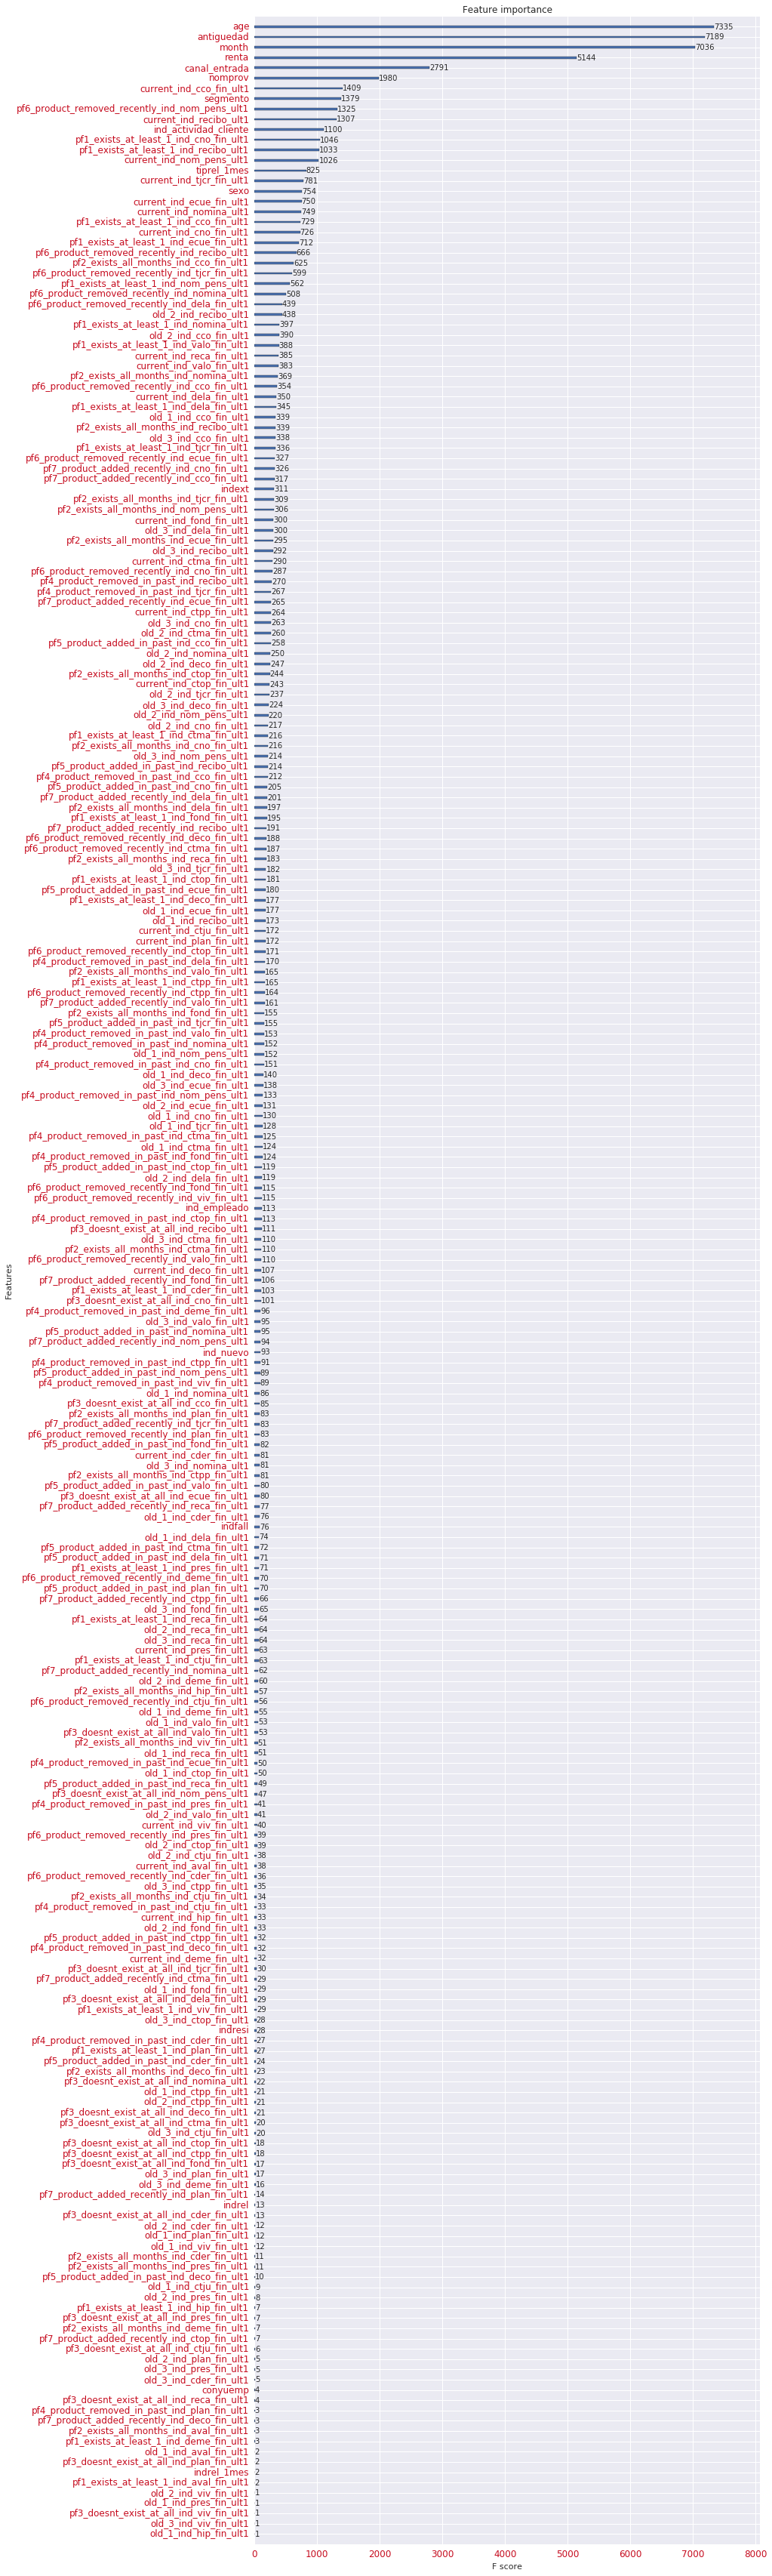

time: 4.43 s


In [127]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")

In [128]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

100%|██████████| 929615/929615 [13:25<00:00, 1154.78it/s]


time: 13min 58s


In [131]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.3.xgb_trained_on_all_months_subs_lags_tuned_n_iters.csv'
description = '14.3 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               removed user attribute change features also\
               xgb model tuned itres iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param) + " n iters " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.3.xgb_trained_on_all_months_subs_lags_tuned_n_iters.csv.zip
uploading to s3 done
Uploading submission data/14.3.xgb_trained_on_all_months_subs_lags_tuned_n_iters.csv.zip
Upload done
time: 15.6 s


In [130]:
pickle_description = '14.3 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.3.xgb_trained_on_all_months_subs_lags_tuned_n_iters.csv.pickle.zip
uploading to s3 done
time: 1min 17s


---
# 14.4 finding optimal_n for user attr lag features data set
---

In [132]:
description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))
description, test1 = pickle.load(open('data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2

time: 1min 34s


In [133]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

time: 3.49 ms


In [134]:
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 250
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 388) (22082, 3)
(419570, 388) (419570, 3)
time: 6.27 s


In [135]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.755712	cv-MAP@7:0.754687
[1]	train-MAP@7:0.762481	cv-MAP@7:0.761933
[2]	train-MAP@7:0.763861	cv-MAP@7:0.763156
[3]	train-MAP@7:0.764559	cv-MAP@7:0.764197
[4]	train-MAP@7:0.764928	cv-MAP@7:0.764514
[5]	train-MAP@7:0.765767	cv-MAP@7:0.765148
[6]	train-MAP@7:0.765898	cv-MAP@7:0.764876
[7]	train-MAP@7:0.766663	cv-MAP@7:0.764695
[8]	train-MAP@7:0.768577	cv-MAP@7:0.766235
[9]	train-MAP@7:0.768947	cv-MAP@7:0.766688
[10]	train-MAP@7:0.769276	cv-MAP@7:0.766869
[11]	train-MAP@7:0.769676	cv-MAP@7:0.76705
[12]	train-MAP@7:0.769876	cv-MAP@7:0.767458
[13]	train-MAP@7:0.770046	cv-MAP@7:0.767775
[14]	train-MAP@7:0.770353	cv-MAP@7:0.767911
[15]	train-MAP@7:0.770677	cv-MAP@7:0.767548
[16]	train-MAP@7:0.770775	cv-MAP@7:0.768182
[17]	train-MAP@7:0.771008	cv-MAP@7:0.767911
[18]	train-MAP@7:0.771099	cv-MAP@7:0.768092
[19]	train-MAP@7:0.771192	cv-MAP@7:0.768228
[20]	train-MAP@7:0.771409	cv-MAP@7:0.768454
[21]	train-MAP@7:0.771507	cv-MAP@7:0.767956
[22]	train-MAP@7:0.771588	cv-MAP@7:0.768318

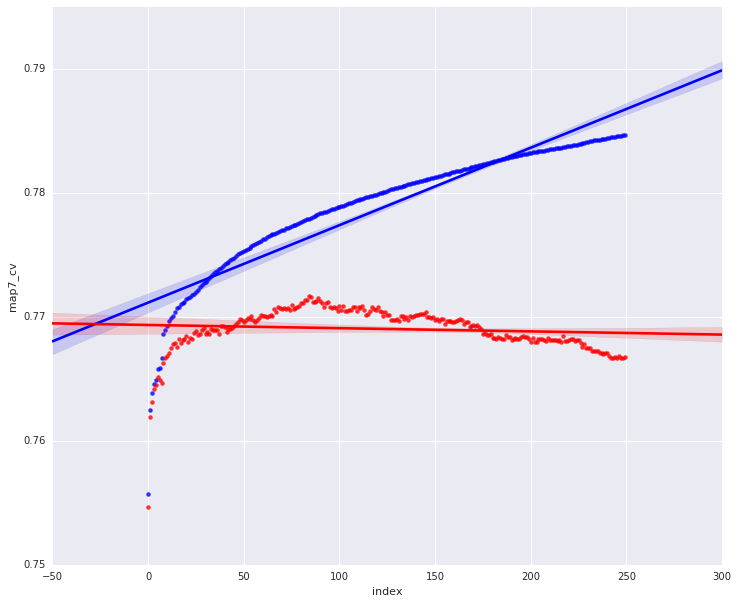

time: 436 ms


In [136]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
p2.loc[p2.map7_cv == p2.map7_cv.max(), :].index.max()

In [137]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95) + 20
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

    index  map7_train   map7_cv
84     84    0.777896  0.771669
@@@@@@@@ Results @@@@@@@@
108 optimal_n 84
time: 7.9 ms


In [138]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 4.84 s


In [139]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.752265	cv-MAP@7:0.754234
[1]	train-MAP@7:0.756596	cv-MAP@7:0.758038
[2]	train-MAP@7:0.7608	cv-MAP@7:0.762657
[3]	train-MAP@7:0.762895	cv-MAP@7:0.763744
[4]	train-MAP@7:0.76331	cv-MAP@7:0.764333
[5]	train-MAP@7:0.764187	cv-MAP@7:0.766054
[6]	train-MAP@7:0.764936	cv-MAP@7:0.76705
[7]	train-MAP@7:0.766299	cv-MAP@7:0.767911
[8]	train-MAP@7:0.768248	cv-MAP@7:0.769677
[9]	train-MAP@7:0.768394	cv-MAP@7:0.769858
[10]	train-MAP@7:0.76889	cv-MAP@7:0.770039
[11]	train-MAP@7:0.769264	cv-MAP@7:0.770492
[12]	train-MAP@7:0.769435	cv-MAP@7:0.770673
[13]	train-MAP@7:0.76976	cv-MAP@7:0.770718
[14]	train-MAP@7:0.77005	cv-MAP@7:0.771035
[15]	train-MAP@7:0.770365	cv-MAP@7:0.771669
[16]	train-MAP@7:0.770403	cv-MAP@7:0.771488
[17]	train-MAP@7:0.77061	cv-MAP@7:0.771805
[18]	train-MAP@7:0.770906	cv-MAP@7:0.771579
[19]	train-MAP@7:0.770996	cv-MAP@7:0.772077
[20]	train-MAP@7:0.771159	cv-MAP@7:0.772258
[21]	train-MAP@7:0.771306	cv-MAP@7:0.772439
[22]	train-MAP@7:0.771435	cv-MAP@7:0.772303
[23]	t

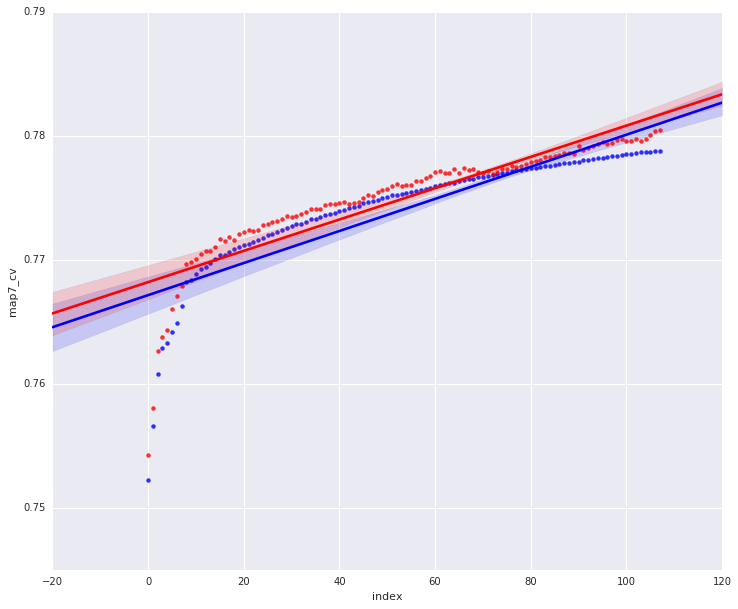

time: 382 ms


In [140]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

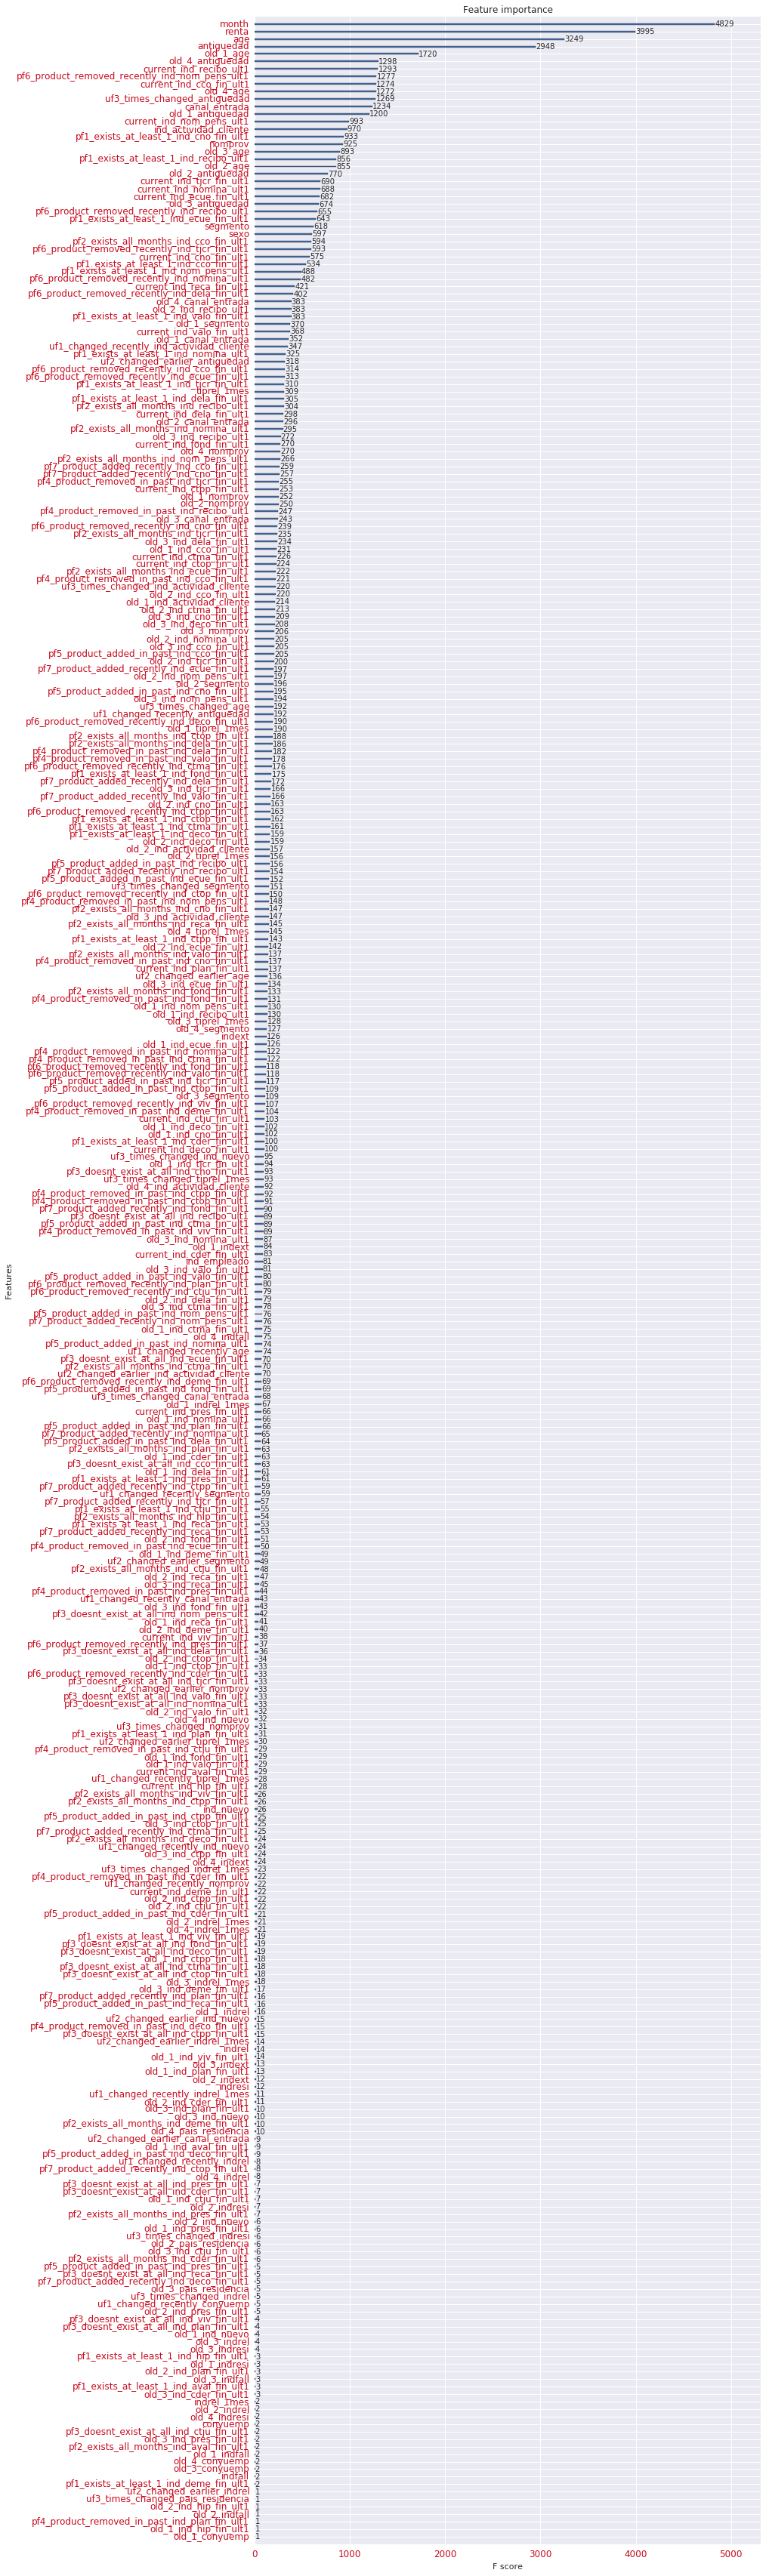

time: 6.09 s


In [141]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")

In [142]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

100%|██████████| 929615/929615 [15:07<00:00, 1024.29it/s]


time: 15min 45s


In [143]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.4.xgb_trained_on_all_months_user_lags_subs_lags_tuned_n_iters.csv'
description = '14.4 (feature engineering was done in 13.)\
               xgb model tuned itres iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param) + " n iters " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.4.xgb_trained_on_all_months_user_lags_subs_lags_tuned_n_iters.csv.zip
uploading to s3 done
Uploading submission data/14.4.xgb_trained_on_all_months_user_lags_subs_lags_tuned_n_iters.csv.zip
Upload done
time: 18.1 s


In [144]:
pickle_description = '14.4 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.4.xgb_trained_on_all_months_user_lags_subs_lags_tuned_n_iters.csv.pickle.zip
uploading to s3 done
time: 1min 5s


---
# 14.5 Training only on July 2015
---

In [145]:
train.reset_index('ncodpers', inplace=True)

time: 3.62 ms


In [148]:
added_products.reset_index('ncodpers', inplace=True)

time: 3.37 ms


In [151]:
train = train.loc[:41474, ]
added_products = added_products.loc[:41474, ]
print train.shape
print added_products.shape

(41475, 389)
(41475, 3)
time: 10.2 ms


In [152]:
train.tail()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
41470,1397804,3,36,2,30,1.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
41471,1397808,3,36,2,47,1.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
41472,1397808,3,36,2,47,1.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
41473,1397816,3,36,2,26,1.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
41474,1397820,3,36,0,54,1.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


time: 26.5 ms


In [154]:
added_products.tail()

,ncodpers,added_product,encoded_products
41470,1397804,ind_ecue_fin_ult1,12
41471,1397808,ind_ctma_fin_ult1,6
41472,1397808,ind_deco_fin_ult1,9
41473,1397816,ind_recibo_ult1,20
41474,1397820,ind_deco_fin_ult1,9


time: 9.4 ms


In [155]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

time: 53.8 ms


In [156]:
del test['xgb_preds'], test['added_products']

time: 99.6 ms


In [157]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

time: 3.32 ms


In [158]:
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 400
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(2073, 388) (2073, 3)
(39402, 388) (39402, 3)
time: 599 ms


In [159]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.775265	cv-MAP@7:0.758321
[1]	train-MAP@7:0.776839	cv-MAP@7:0.759768
[2]	train-MAP@7:0.777651	cv-MAP@7:0.756392
[3]	train-MAP@7:0.778539	cv-MAP@7:0.755427
[4]	train-MAP@7:0.778844	cv-MAP@7:0.75398
[5]	train-MAP@7:0.779377	cv-MAP@7:0.753497
[6]	train-MAP@7:0.779707	cv-MAP@7:0.755909
[7]	train-MAP@7:0.780341	cv-MAP@7:0.754462
[8]	train-MAP@7:0.780468	cv-MAP@7:0.758804
[9]	train-MAP@7:0.781179	cv-MAP@7:0.75398
[10]	train-MAP@7:0.781356	cv-MAP@7:0.754462
[11]	train-MAP@7:0.781813	cv-MAP@7:0.754462
[12]	train-MAP@7:0.781991	cv-MAP@7:0.75398
[13]	train-MAP@7:0.782321	cv-MAP@7:0.753497
[14]	train-MAP@7:0.7826	cv-MAP@7:0.751568
[15]	train-MAP@7:0.782854	cv-MAP@7:0.751085
[16]	train-MAP@7:0.783158	cv-MAP@7:0.750603
[17]	train-MAP@7:0.78331	cv-MAP@7:0.751568
[18]	train-MAP@7:0.783463	cv-MAP@7:0.753015
[19]	train-MAP@7:0.783818	cv-MAP@7:0.75205
[20]	train-MAP@7:0.78392	cv-MAP@7:0.751568
[21]	train-MAP@7:0.784173	cv-MAP@7:0.75205
[22]	train-MAP@7:0.784478	cv-MAP@7:0.751568
[23]	tr

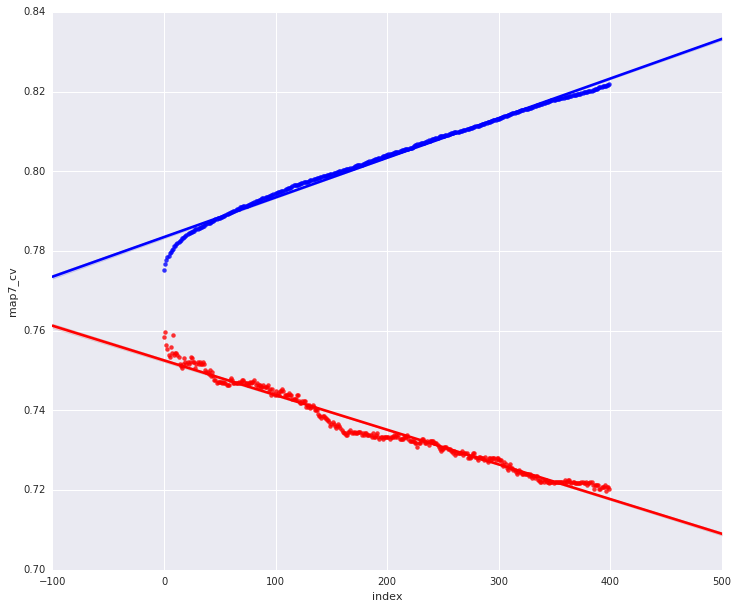

time: 490 ms


In [160]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [ ]:
p2.loc[p2.map7_cv == p2.map7_cv.max(), :].index.max()

In [161]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

   index  map7_train   map7_cv
1      1    0.776839  0.759768
@@@@@@@@ Results @@@@@@@@
1 optimal_n 1
time: 8.21 ms


In [162]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 452 ms


In [163]:
# optimal n in this case was found to be 116
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.774174	cv-MAP@7:0.768934
time: 3.58 s


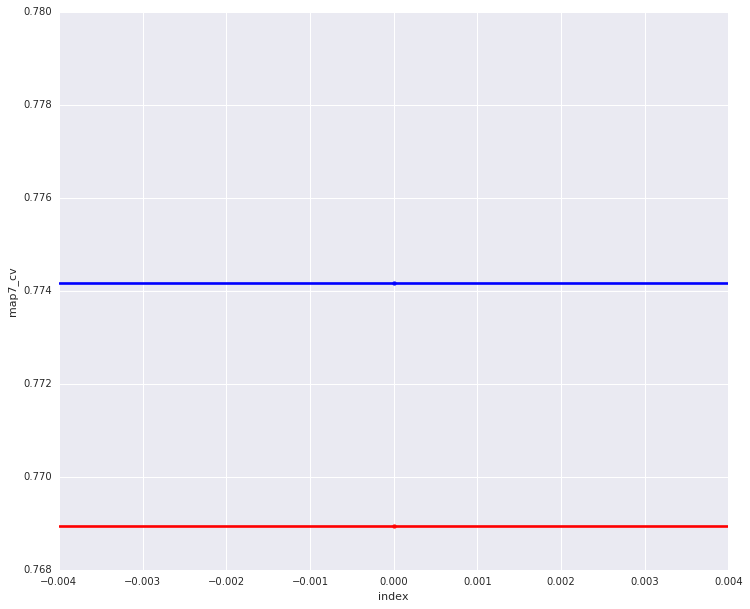

time: 609 ms


In [164]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

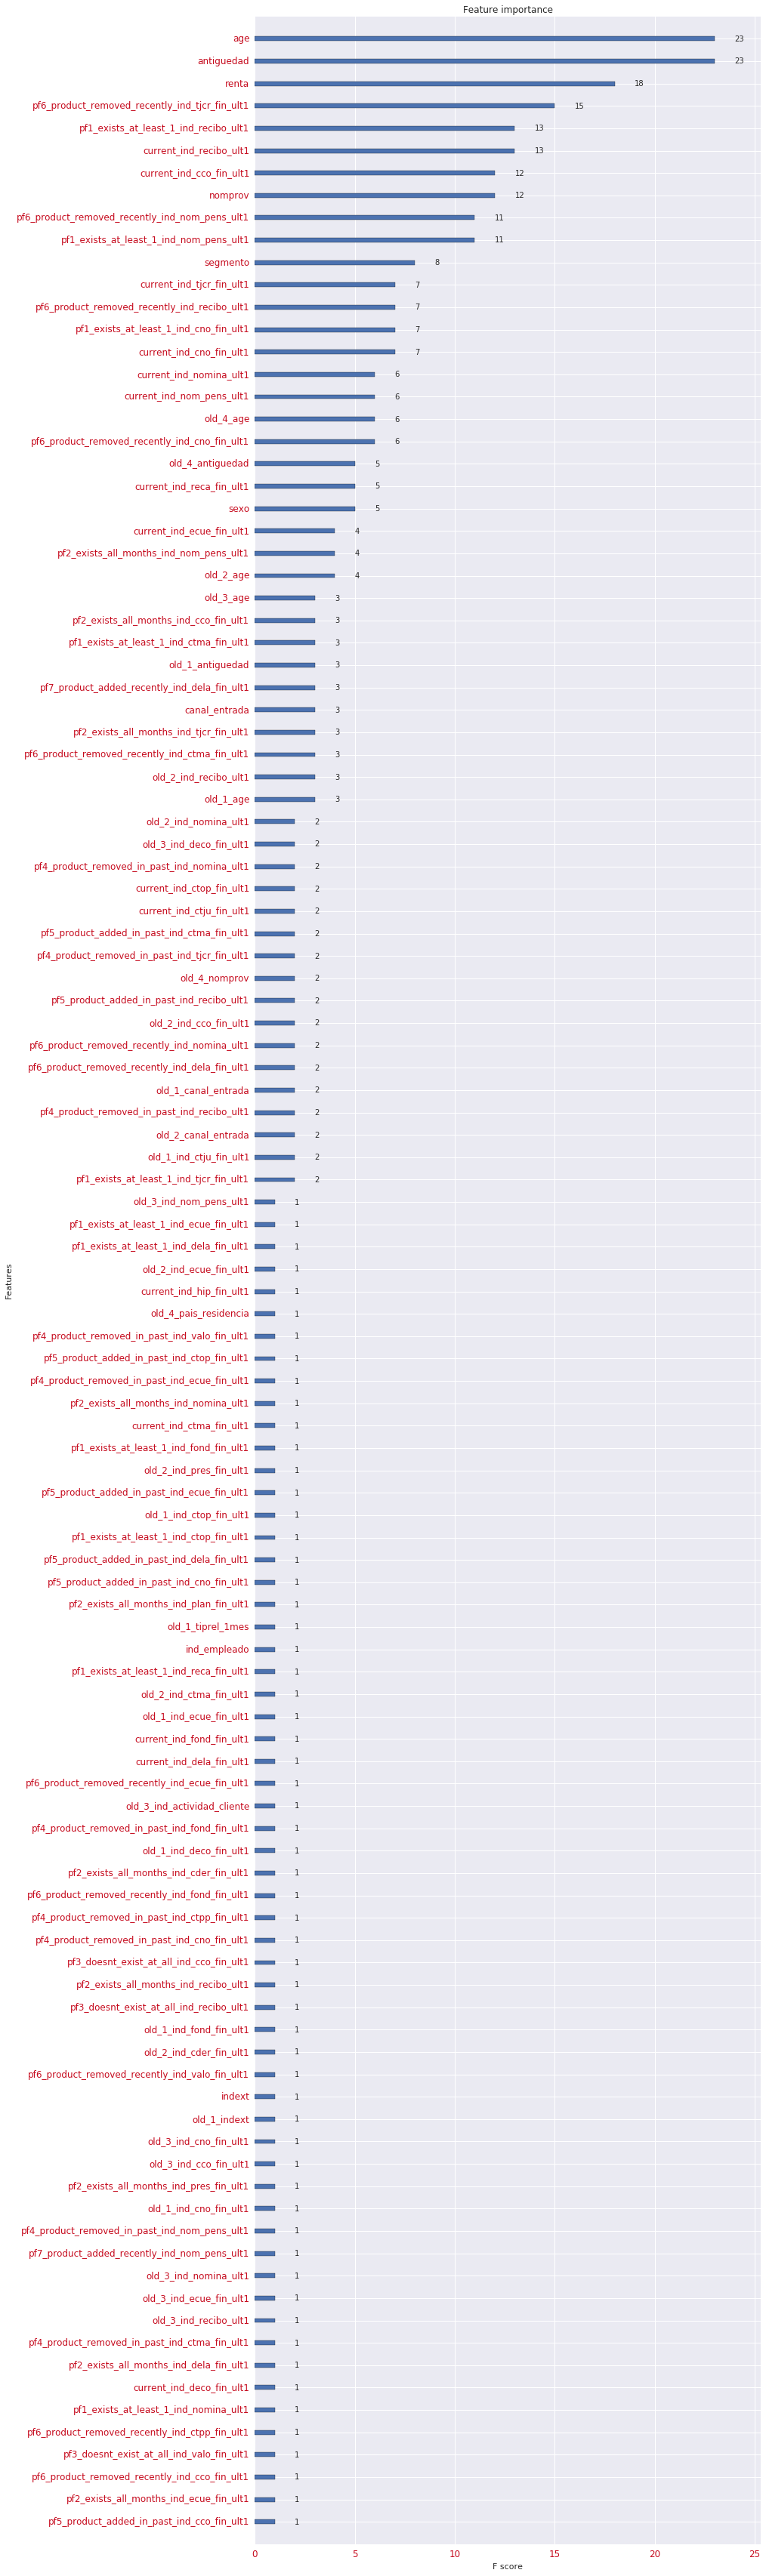

time: 2.12 s


In [165]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")

In [166]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

 12%|█▏        | 111988/929615 [01:49<12:46, 1066.49it/s]


KeyboardInterrupt: 

time: 2min 2s


In [ ]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.5.xgb_trained_on_july_2015_subs_lags_tuned_n_iters.csv'
description = '14.5 (feature engineering was done in 13.)\
               trained only on july 2015, with user attrs raw lags and its features\
               xgb model tuned itres iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param) + " n iters " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

In [ ]:
pickle_description = '14.5 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)